<a href="https://colab.research.google.com/github/S3688570/Cars_Deep_Learning/blob/master/CNN_Cars_train_predict_final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Learning Model to Recognize Vehicle Accidents

In [38]:
from google.colab import drive, files
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My\ Drive/Colab\ Notebooks/'
!rsync -ah --progress\
    {gdrive_path}cars_dl/*.zip\
    {gdrive_path}model_weights_final*.h5\
    {gdrive_path}model_structure_final*.json\
    '/content'
!unzip -qo '*.zip'
!rm *.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
sending incremental file list
rsync: link_stat "/content/gdrive/My Drive/Colab Notebooks/model_weights_final*.h5" failed: No such file or directory (2)
rsync: link_stat "/content/gdrive/My Drive/Colab Notebooks/model_structure_final*.json" failed: No such file or directory (2)
cars-20191002T050118Z-001.zip
        490.68M 100%  142.96MB/s    0:00:03 (xfr#1, to-chk=0/1)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1196) [sender=3.1.2]


##Import Keras library and packages

In [2]:
# Importing the Keras libraries and packages
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras import backend as K
from keras.preprocessing import image
from keras import regularizers
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


##Set parameters

In [0]:
epochs = 50 #@param {type:"number"}
validation_steps = 32 #@param {type:"number"}
img_height = 128 #@param {type:"integer"}
img_width = 128 #@param {type:"integer"}
batch_size = 32 #@param {type:"number"}


##Set data filepaths

In [4]:
trainingCarImages = os.listdir('cars/training_set/car/')
print ("Number of Training car images - ",str(len(trainingCarImages)))

trainingCrashImages = os.listdir('cars/training_set/crash/')
print ("Number of Training crash images - ",str(len(trainingCrashImages)))

validCarImages = os.listdir('cars/val_set/car/')
print ("Number of Validation car images - ",str(len(validCarImages)))

validCrashImages = os.listdir('cars/val_set/crash/')
print ("Number of Validation crash images - ",str(len(validCrashImages)))

testCarImages = os.listdir('cars/test_set/car/')
print ("Number of Test car images - ",str(len(testCarImages)))

testCrashImages = os.listdir('cars/test_set/crash/')
print ("Number of Test crash images - ",str(len(testCrashImages)))

Number of Training car images -  1445
Number of Training crash images -  1445
Number of Validation car images -  375
Number of Validation crash images -  372
Number of Test car images -  129
Number of Test crash images -  131


##Print image from training folder

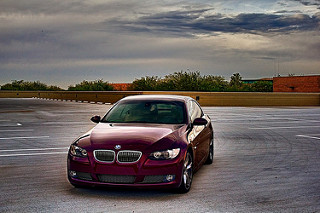

In [5]:
trainFilename = 'cars/training_set/car/'+trainingCarImages[2]
dimage = Image.open(trainFilename)
dimage

##Print image from validation folder

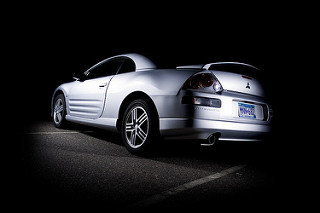

In [6]:
validFilename = 'cars/val_set/car/'+validCarImages[5]
dimage = Image.open(validFilename)
dimage

##Print image from test folder

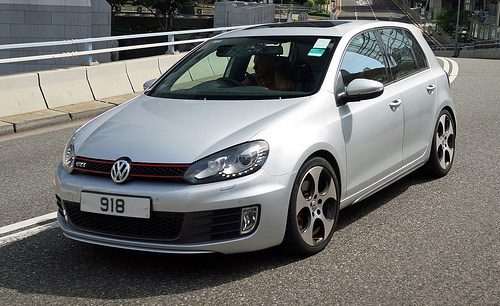

In [7]:
testFilename = 'cars/test_set/car/'+ testCarImages[30]
dimage = Image.open(testFilename)
dimage

###Determine image dimensions

In [8]:
train_data_dir = 'cars/training_set/'
validation_data_dir = 'cars/val_set/'
test_data_dir = 'cars/test_set/'
nb_train_samples = trainingCarImages + trainingCrashImages
nb_validation_samples = validCarImages + validCrashImages
nb_test_samples = testCarImages + testCrashImages

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

print(input_shape)

(128, 128, 3)


In [0]:
#Method to print several images in a single row 
def plots(img, figsize=(12,6), rows = 1, titles = 1):
    if type(img[0]) is np.ndarray:
        img = np.array(img).astype(np.float_)
        if (img.shape[-1] != 3):
            img = img.transpose((0, 2, 3, 1))
    f =plt.figure(figsize = figsize)
    cols = 7//rows if (len(img) % 2 == 0) else len(img)//rows + 1
    for i in range(cols):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 10)
        plt.imshow(img[i], interpolation = None if np.interp else 'none')

##Create CNN model

In [10]:
# Initialising the CNN
classifier = Sequential()

# Layer 1 - convolution
classifier.add(Convolution2D(32, (3, 3), 
              input_shape = (img_width, img_height, 3), 
              activation = 'relu'))                        # Convolution
classifier.add(MaxPooling2D(pool_size = (2, 2)))          # MaxPooling
classifier.add(Dropout(0.25))                             # Dropout


#Add another convolutional layer
# classifier.add(Convolution2D(32, 3, 3, 
#               activation = 'relu'))
# classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Layer 2 - convolution
classifier.add(Convolution2D(32, (3, 3), 
              activation = 'relu', 
              kernel_regularizer=regularizers.l2(0.01)))  # Convolution layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))          # MaxPooling
classifier.add(Dropout(0.25))                             # Dropout

# Layer 3 - convolution
classifier.add(Convolution2D(32, (3, 3), 
              activation = 'relu'))                       # Convolution layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))          # MaxPooling
classifier.add(Dropout(0.25))                             # Dropout

# Layer 4 - convolution
classifier.add(Convolution2D(32, (3, 3), 
              activation = 'relu'))                       # Convolution layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))          # MaxPooling
classifier.add(Dropout(0.25))                             # Dropout

classifier.add(Flatten())                                 # Flattening

# Fully connected layer
classifier.add(Dense(output_dim = 256, 
                     activation = 'relu'))                # Dense layer
classifier.add(Dropout(0.25))                             # Dropout
classifier.add(Dense(output_dim = 2, 
                     activation = 'softmax'))             # Output

classifier.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`


##Compiling the CNN

In [11]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


##Data standardization and augmentation of training data

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True
                                   )

training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = (img_width, img_height),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=42)

test_datagen = ImageDataGenerator(rescale = 1./255)

val_set = test_datagen.flow_from_directory(validation_data_dir,
                                            target_size = (img_width, img_height),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle=True,
                                            seed=42)

test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = (img_width, img_height),
                                            batch_size = batch_size,
                                            class_mode = 'categorical'
                                            )


Found 2890 images belonging to 2 classes.
Found 747 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


##Print normalized and re-sized images from training set

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


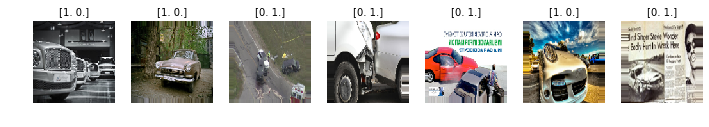

In [13]:
imgs, labels = next(training_set)
plots(imgs, titles = labels)

##Print normalized and re-sized images from validation set

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


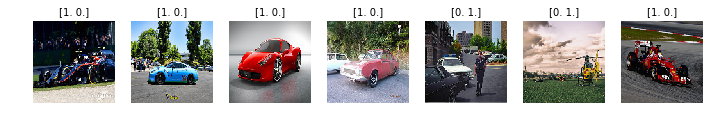

In [14]:
imgs, labels = next(val_set)
plots(imgs, titles = labels)

In [0]:
#Method to identify and remove corrupted images
def my_gen(gen):
    while True:
        try:
            imgs, labels = next(gen)
            yield imgs, labels
        except:
            pass

##Training the CNN model

In [16]:
history = classifier.fit_generator(my_gen(training_set),
                         steps_per_epoch = 78,
                         epochs = epochs,
                         validation_data = val_set,
                         validation_steps = validation_steps)




Epoch 1/50





36/78 [============>.................] - ETA: 22s - loss: 0.9489 - acc: 0.5399

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


78/78 [==============================] - 44s 565ms/step - loss: 0.8839 - acc: 0.5457 - val_loss: 0.7986 - val_acc: 0.4965
Epoch 2/50
78/78 [==============================] - 37s 480ms/step - loss: 0.7383 - acc: 0.5880 - val_loss: 0.6595 - val_acc: 0.6929
Epoch 3/50
78/78 [==============================] - 36s 461ms/step - loss: 0.6470 - acc: 0.6722 - val_loss: 0.5711 - val_acc: 0.7393
Epoch 4/50
78/78 [==============================] - 36s 464ms/step - loss: 0.6129 - acc: 0.7078 - val_loss: 0.5382 - val_acc: 0.7866
Epoch 5/50
78/78 [==============================] - 37s 477ms/step - loss: 0.5806 - acc: 0.7273 - val_loss: 0.4868 - val_acc: 0.7996
Epoch 6/50
78/78 [==============================] - 35s 452ms/step - loss: 0.5677 - acc: 0.7352 - val_loss: 0.5452 - val_acc: 0.6996
Epoch 7/50
78/78 [==============================] - 36s 465ms/step - loss: 0.5351 - acc: 0.7578 - val_loss: 0.4955 - val_acc: 0.7587
Epoch 8/50
78/78 [==============================] - 36s 460ms/step - loss: 0.525

In [33]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [63]:
!ls '/My Drive/Colab Notebooks'

ls: cannot access '/My Drive/Colab Notebooks': No such file or directory


In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Save neural network structure

In [66]:
from pathlib import Path
import os
model_struct_final = classifier.to_json()
f = Path("/content/drive/My Drive/Colab Notebooks/model_struct_final.json")
f.write_text(model_struct_final)

5328

## Save neural network's trained weights

In [0]:
# Save neural network's trained weights
classifier.save_weights("/content/drive/My Drive/Colab Notebooks/model_weights_final.h5")

##Plot training and validation accuracy per epoch

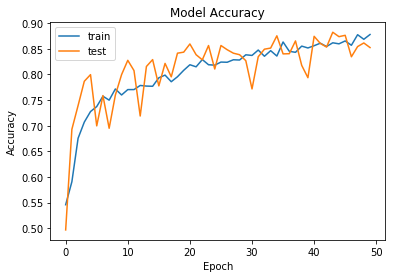

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Plot training and validation loss per epoch

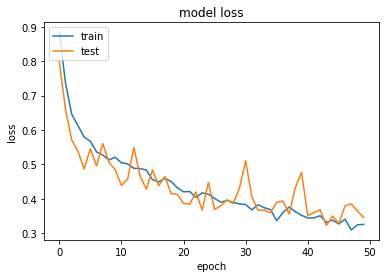

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
training_set.class_indices

{'car': 0, 'crash': 1}

##Prediction

0.9375169
0.8874122
0.94651306
0.26875815
0.009791187


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


0.48972613
0.056924686


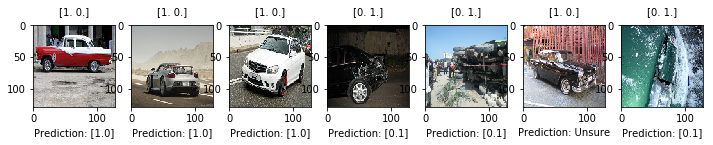

In [23]:
#Method to print several images in a single row 
def plots(img, figsize=(12,6), rows = 1, titles = 1):
  
  if type(img[0]) is np.ndarray:
    img = np.array(img).astype(np.float_)
  if (img.shape[-1] != 3):
    img = img.transpose((0, 2, 3, 1))
  f =plt.figure(figsize = figsize)
  cols = 7//rows if (len(img) % 2 == 0) else len(img)//rows + 1
  
  for i in range(cols):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('On')
    
    result = classifier.predict(img)
    print(result[i][0])
    test_set.class_indices
    if result[i][0] < 0.3:
      prediction = '[0.1]'
    elif result[i][0] > 0.7: 
      prediction = '[1.0]'
    else:
      prediction = 'Unsure'

    if titles is not None:
      sp.set_title(titles[i], fontsize = 10, pad = 10)
      sp.set_xlabel('Prediction: ' + prediction)
    plt.imshow(img[i], interpolation = None if np.interp else 'none')


imgs, labels = next(test_set)
plots(imgs, titles = labels)

###Process images and store in different folder

In [0]:
import os, shutil

# The directory where we will store our cars dataset
base_dir = 'cars_pro/'
os.mkdir(base_dir)

# Directories for our training, validation and test splits
test_dir = os.path.join(base_dir, 'test_set_pro')
os.mkdir(test_dir)

In [25]:
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path


test_data_dir = 'cars/test_set/'

# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode = 'categorical')

print("OK")
for data_batch, labels_batch in test_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

Found 260 images belonging to 2 classes.
OK
data batch shape: (10, 128, 128, 3)
labels batch shape: (10, 2)


Exception ignored in: <generator object my_gen at 0x7f0d5bf5daf0>
RuntimeError: generator ignored GeneratorExit


In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image
import matplotlib.pyplot as plt
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

datagen = ImageDataGenerator(
    rescale=1./255
    )

test_data_dir = 'cars/test_set/car/'
fnames = [os.path.join(test_data_dir, fname) for fname in os.listdir(test_data_dir)]

for i in range(1, len(fnames), 1):
  # We pick one image to "augment"
  img_path = fnames[i]
  
  # Read the image and resize it
  img = image.load_img(img_path, target_size=(128, 128))
  
  # Convert it to a Numpy array with shape (128, 128, 3)
  x = image.img_to_array(img)
  
  # Reshape it to (1, 128, 128, 3)
  x = x.reshape((1,) + x.shape)
  
  car_pro_dir = 'cars_pro/'
  img.save(os.path.join(car_pro_dir, 'car' + str(i) + '.jpg'))


##Confusion matrix and classification report

In [27]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = classifier.predict_classes(car_pro_dir)
type(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

print(confusion_matrix(y_true = car_pro_dir.classes, y_pred = y_pred))
#confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)  # shape=(12, 12)


print('Classification Report')

target_names = ['Yes', 'No']

print(classification_report(y_true = car_pro_dir.classes, y_pred = y_pred, target_names = target_names))

AttributeError: ignored